In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### pET15

In [6]:
seq = pd.read_csv('/home/bikash/Documents/Solubility/results/pET15_cleaned.csv')

#R analysis files

path = r'/home/bikash/Documents/Solubility/protr_R_Package_analysis/pET/protr_pET15_NESG'  # use your path
all_files = glob.glob(os.path.join(path, '*.txt'))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = [pd.read_csv(f, sep='\t') for f in all_files]


#merge all features

from functools import reduce
all_f = reduce(lambda x,y: pd.merge(x,y, on='Accession', how='outer'), df_from_each_file)

#merge features with sequence

total = pd.merge(seq, all_f, on="Accession", how="outer")

total.dropna(inplace=True)

total.to_csv('pET15_All.csv', index=None)

#### pET21

In [7]:
seq = pd.read_csv('/home/bikash/Documents/Solubility/results/pET21_cleaned.csv')

#R analysis files

path = r'/home/bikash/Documents/Solubility/protr_R_Package_analysis/pET/protr_pET21_NESG'  # use your path
all_files = glob.glob(os.path.join(path, '*.txt'))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = [pd.read_csv(f, sep='\t') for f in all_files]


#merge all features

from functools import reduce
all_f = reduce(lambda x,y: pd.merge(x,y, on='Accession', how='outer'), df_from_each_file)

#merge features with sequence

total = pd.merge(seq, all_f, on="Accession", how="outer")

total.dropna(inplace=True)

total.to_csv('pET21_All.csv', index=None)

In [8]:
pET15 = pd.read_csv('/home/bikash/Documents/Solubility/For_upload/Solubility1/protr_R_Package_analysis/pET/pET15_All.csv')
pET21 = pd.read_csv('/home/bikash/Documents/Solubility/For_upload/Solubility1/protr_R_Package_analysis/pET/pET21_All.csv')


pET = pd.concat([pET15, pET21], sort=False)
pET.to_pickle('pET.pkl.gz', compression='infer')

## AUC

In [4]:
pET = pd.read_pikcle('pET.pkl.gz')

In [23]:
# column we need
cols = pET.columns[5:].values
cols = np.append(aa, 'Solubility')

# data for doing corr
data = pET[cols]

df = data.loc[:, data.columns != 'Solubility']
labels = pET.Solubility.values

In [24]:
from sklearn.metrics import roc_curve, auc


def all_rocs(df, labels):
    aucs = []
    for i, col in enumerate(df.columns):
        preds = df[col].values
        fpr, tpr, _ = roc_curve(labels, preds)
        a = auc(fpr, tpr)
        if a <= 0.5:
            a = 1 - a
        aucs.append(a)
        
    return aucs



In [25]:
rocs = all_rocs(df, labels)
rocs_df = pd.DataFrame({'Features':df.columns, 'AUC':rocs})
rocs_df = rocs_df.sort_values('AUC', ascending=False).reset_index(drop=True)

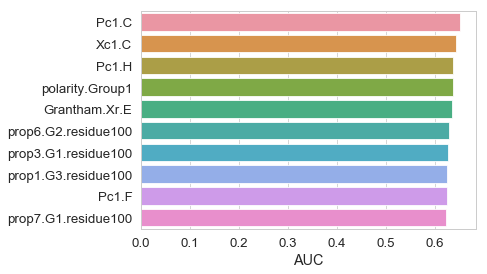

In [30]:
import seaborn as sns
sns.set_palette("Set2")
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

ax = sns.barplot(x=rocs_df.AUC.values[:10], y=rocs_df.Features[:10])
ax.set(xlabel='AUC')
ax.set(ylabel='')
plt.savefig("top_features_pET.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()


In [28]:
rocs_df.loc[rocs_df['AUC'] == max(rocs_df['AUC'])]

,Features,AUC
0,Pc1.C,0.650692


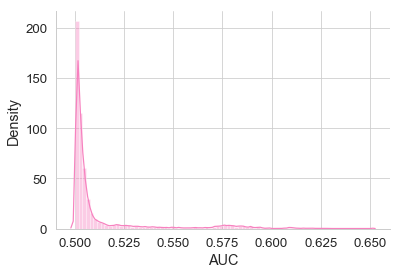

In [31]:
sns.set_palette("Set1_r")
ax = sns.distplot(rocs_df['AUC'], bins=80)
ax.set(ylabel='Density')
sns.despine()
plt.savefig("kde_features_pET.pdf", bbox_inches='tight', pad_inches=0)